# Stage 3 AI training: Main architecture

This stage focuses on selecting the **optimal model's main architecture**. Different architectures and rotational frames will be used for every magnetic component option.

In [1]:
# Import packages:
import MLQDM.MLmodel as ML_MLmodel
import MLQDM.timewindows as ML_twdw
import tensorflow as tf

# Check available GPU:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-10-26 07:19:50.543725: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 07:19:51.135656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 07:19:51.135738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 07:19:51.209193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 07:19:51.337904: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2024-10-26 07:19:53.104499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-26 07:19:53.600115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-26 07:19:53.600260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Load original data and general parameters
Load data from files (many segments) and store information in dataframes, one for each segment. The original data is in the **Laboratory rotational frame (RF1)**.

There are two possible sets of target labels, coming for the 'linear approximation' of 'physical model' approaches regarding the interpolated positions. You must choose one as {interp} for the training stage:
* **'lin_approx'** : linear approximation.
* **'phys_model'** : physical model based on acceleration profile.

In [2]:
# Choose Z-position interpolation method:
interp = 'phys_model' # 'phys_model' or 'lin_approx'

# Prepare files information:
data_path =  'Data/Final_t_BxByBz_zAut_LabFrame/' # Datafiles path
gen_pars_path = 'ML_parameters/'

# Load data, general hyperparameters and rotational frames:
data, hypers, RFs = ML_MLmodel.load_data_and_gen_pars(
    data_path,gen_pars_path,interp=interp,final_stage=False)

## Generate time windows

### Load original data

Each data segment is processed into time windows, which must have a fixed time length (or equivalently, fixed number of points) by default. However, as the original data is stored in the Time_Wdw object, it can be reshaped later.

The distribution of training and testing datasets is chosen here. The validation dataset is included within the training dataset.

Summary for time windows within training and testing datasets:

Number of points for every time window: 40
Time resolution: 0.1000 s

 --------------------  Training dataset  -------------------- 

Segment1: 35719 points, 59 min
Segment2: 107601 points, 179 min
Segment3: 70561 points, 117 min
Total points/time: 213881 / 5.94 hours

 --------------------  Testing dataset  -------------------- 

Segment4: 107138 points, 178 min
Segment5: 105475 points, 175 min
Total points/time: 212613 / 5.91 hours


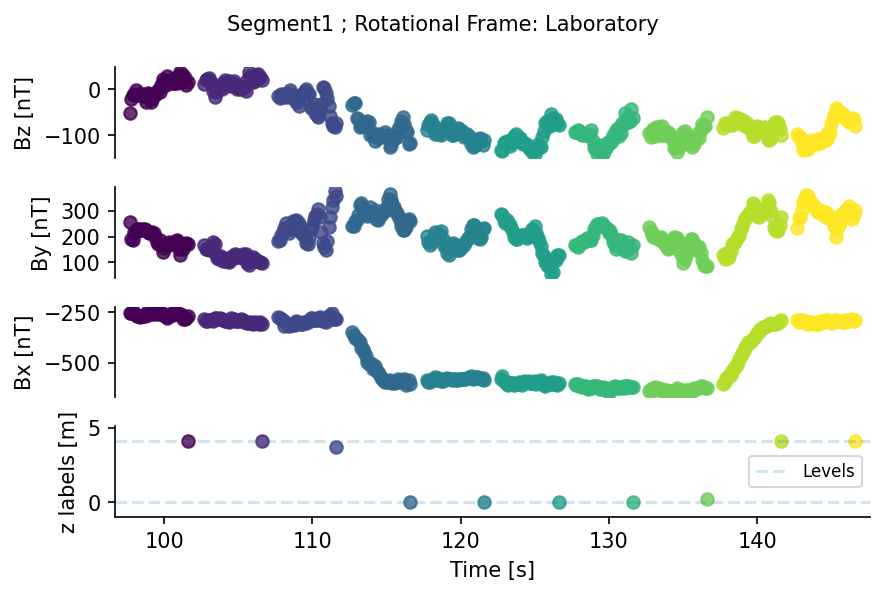

In [3]:
# Prepare time windows:
wdw_pp = 40
train_segm = [0,1,2]
t_wdws_train, t_wdws_test = ML_twdw.prepare_time_windows(
    data,wdw_pp,train_segm=train_segm,
    plot_instances=True,instances=10,start_wdw=975,stride_pp=50)

### Main architecture

From Stage 1 analysis, we've determined that only the full vector data, meaning all three $(Bx,By,Bz)$ magnetic components, is robust against rotations and has about 90% accuracy for position predictions using a 1-meter threshold.
From Stage 2, we've determined that increasing the number of time window points is associated with better ML performance, up to a certain limit. Using 40 points (equal to 4s) is a good compromise between performance and complexity of the ML model. We also proved that for time windows longer than 2s (20 points), the ML model works much better if Convolutional Neural Networks (CNN) are combined with Dense Neural Networks (DNN). 
In this stage, we explore different options for the main architecture of the ML model, including the number of CNN and DNN, the CNN kernel sizes, and the DNN number of neurons.

**Architectures**:
The format for denoting neural networks is the following: CNN are described by [filters,kernel] layers; DNN are described by [neurons] layers.

We propose different Convolutional and Dense block that will be combined. 

Convolutional blocks:

* [32,5]
* [32,8]+[32,4]
* [32,16]+[32,4]

Dense blocks:

* [256]
* [1024]
* [256]+[128]
* [1024]+[512]
* [2048]+[512]+[128]

Additionally, all CNN within the Convolutional block will have the same **pooling options**: either no pooling or pooling layer with size 2.

On the other hand, the Convolutional and Dense block are interfaced by an intermediate **1D-conversion layer**, for which there will be two alternative options: Flattening or Global average. 

In [4]:
# Define additional hyperparameters:
extra_hypers = {
    "Magnetic_Components": ['Bx','By','Bz'],
    "Time_Window_pp": wdw_pp,
    "Dropout_Fraction": 0,
    "Activation_Function": 'relu',
    "Optimizer": 'adam',
    "Learning_Rate": 0.005,
    "Convolutional_Network": True
}

# Define options for blocks in main architecture:
Conv_opts = [[[32,5]], [[32,8],[32,4]], [[32,16],[32,4]]] # Convolutional
pool_opts = [None,2] # Pooling
conversion1D_opts = ['Flatten','Glob'] # 1D-conversion
Dense_opts = [[256],[1024],[256,128],[1024,512],[2048,512,128]] # Dense1

# Combine all general hyperparameters:
gen_hyps = hypers | extra_hypers

# Prepare rotational frame options:
RF_opts = list(RFs.values())

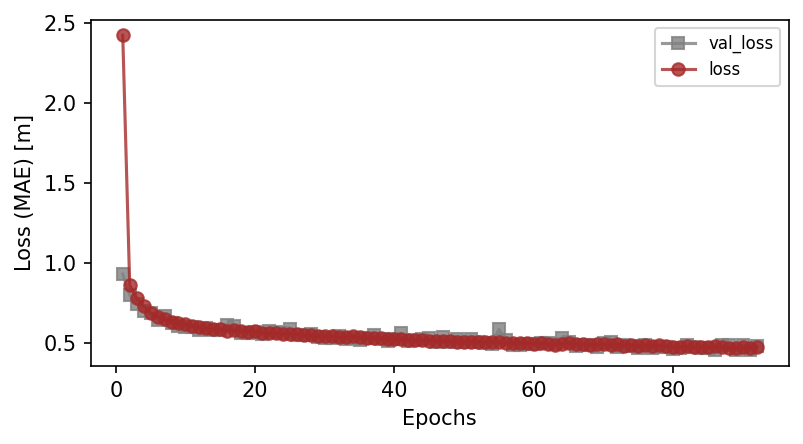

314/314 [==============================] - 1s 3ms/step - loss: 0.4757 - val_loss: 0.4792
Epoch 93/200
215/314 [===================>..........] - ETA: 0s - loss: 0.4728

KeyboardInterrupt: 

In [5]:
# Prepare file path to export results:
results_path = f'Results_{interp}/Train_s1s2s3_Test_s4s5/'
# Prepare file path to check on already trained models and avoid repetitions:
check_rep_model = f'Results_{interp}/Train_s1s2s3_Test_s4s5/Stage3_{interp}_all_Train_s1s2s3_Test_s4s5.csv'

# Train all models:
df_results = ML_MLmodel.train_stage3(
    Conv_opts,pool_opts,conversion1D_opts,Dense_opts,
    gen_hyps,RF_opts,t_wdws_train,t_wdws_test,
    results_path=results_path,check_rep_model=check_rep_model,
    quick_timing_test=False
)